# LOCAL SEARCH - ANÁLISE DE RESULTADOS

 - ITA | PG-CTE-S | TE-282 - Meta-heurísticas
 - Professor Dr. Angelo Passaro
 - Aluno: Rafael Caneiro de Oliveira
 - Versao: 0.1
 - Data: 26/10/2021

## Bibliotecas | Parâmetros | Funções

In [78]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from ast import literal_eval
from tqdm.auto import tqdm
import ray
import os

PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 
LOG_PATH = Path(PATH, "./data/log/")
print(LOG_PATH)


/Users/rco/github/s_metaheuristic/data/log


In [79]:
def read_port_files(n_port):
    filepath = Path(RAW_PATH, 'port' + str(n_port) + '.txt')
    with open(filepath) as fp:
        # quantidade de ativos no portfolio
        n_assets = int(fp.readline())
        # armazena as estatisticas do ativo
        r_mean = []
        r_std = []
        for n in range(n_assets):
            line = fp.readline()
            r_mean.append(float(line.strip().split()[0]))
            r_std.append(float(line.strip().split()[1]))

        # obtem o restante da matriz de covariancia
        cnt = 32
        i = []
        j = []
        cov = []
        line = fp.readline()
        while line:
            i.append(int(line.strip().split(' ')[0]))
            j.append(int(line.strip().split(' ')[1]))
            cov.append(float(line.strip().split(' ')[2]))
            line = fp.readline()
    fp.close()
    # retorna dataframe com estatisticas dos ativos do portfolio
    df_stats = pd.DataFrame({'port':n_port,
                             'i':[i_+1 for i_ in range(n_assets)],
                             'r_mean':r_mean,
                             'r_std':r_std})
    print(df_stats.shape)

    # retorna dataframe com matriz de covariancia dos ativos do portfolio
    df_cov_mx = pd.DataFrame({'port':n_port,
                             'i':i,
                             'j':j,
                             'cov':cov})
    print(df_cov_mx.shape)
    return df_stats, df_cov_mx

## Carrega Dados

In [80]:
df_stats_list = []
df_cov_mx_list =[]
for p in range(1,6,1):
    df_stats, df_cov_mx = read_port_files(p)
    df_stats_list.append(df_stats)
    df_cov_mx_list.append(df_cov_mx)
    
df_stats = pd.concat(df_stats_list)
df_cov_mx = pd.concat(df_cov_mx_list)

(31, 4)
(496, 4)
(85, 4)
(3655, 4)
(89, 4)
(4005, 4)
(98, 4)
(4851, 4)
(225, 4)
(25425, 4)


In [81]:
portfolios = {
    1:'Hang Seng - Hong Kong',
    2:'DAX - German Blue Chips',
    3:'FTSE - London',
    4:"S&P - Standard and Poor's 500 - US",
    5:'Nikkei - Tokyo'
}
df_stats['portfolio'] = df_stats.port.map(portfolios)
df_cov_mx['portfolio'] = df_cov_mx.port.map(portfolios)

In [82]:
uefs = []
for port in range(5):
    uef = pd.read_csv(Path(RAW_PATH, 'portef' + str(port+1) + '.txt'), header=None, sep='\s+')
    uef.columns = ['mean_return', 'var_return']
    uef['port'] = port + 1
    uefs.append(uef)
uef = pd.concat(uefs, ignore_index=True).reset_index(drop=True)
uef['portfolio'] = uef.port.map(portfolios)
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


In [83]:
@ray.remote
def import_logs(filename):
    try:
        file_path = Path(LOG_PATH, filename)
        df = pd.read_csv(file_path, low_memory=False)
        df['filename'] = filename
        df.loc[-1:, 'last_iter'] = 1
    except:
        print(filename)

    return df

# ray.init(num_cpus=16)

futures = [import_logs.remote(filename) for filename in os.listdir(LOG_PATH) if filename != '.DS_Store']
dfs = ray.get(futures)


In [84]:

all_data = pd.concat(dfs, ignore_index=True)
all_data.reset_index(drop=True, inplace=True)
all_data.rename({'move_strategy':'move_str', 'selection_strategy':'selec_str'}, axis=1, inplace=True)
best_data = all_data[all_data.last_iter==1]


In [85]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50884 entries, 0 to 50883
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   iter        50884 non-null  int64  
 1   obj         50884 non-null  float64
 2   aug_obj     50884 non-null  float64
 3   return      50884 non-null  float64
 4   X           50884 non-null  object 
 5   Z           50884 non-null  object 
 6   Q           50884 non-null  float64
 7   max_iter    50884 non-null  int64  
 8   neighbours  50884 non-null  int64  
 9   alpha       50884 non-null  float64
 10  exp_return  50884 non-null  float64
 11  n_port      50884 non-null  int64  
 12  k           50884 non-null  int64  
 13  move_str    50884 non-null  object 
 14  seed        50884 non-null  int64  
 15  selec_str   50884 non-null  object 
 16  filename    50884 non-null  object 
 17  last_iter   50884 non-null  int64  
dtypes: float64(6), int64(7), object(5)
memory usage: 7.0+ MB


## Portfólios

### Geral

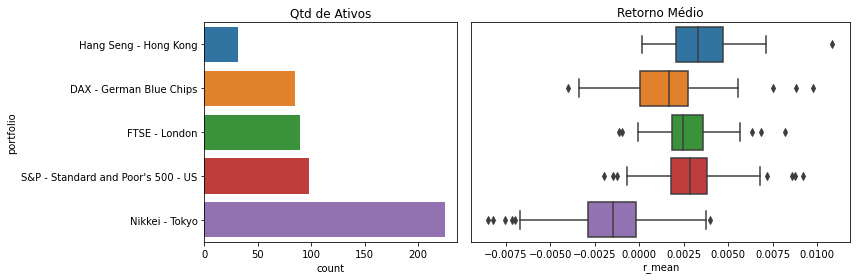

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [1, 1.5]})
sns.countplot(data=df_stats, y='portfolio', ax=ax[0])
ax[0].title.set_text('Qtd de Ativos')
sns.boxplot(data=df_stats, y='portfolio', x='r_mean', ax=ax[1])
ax[1].title.set_text("Retorno Médio")
ax[1].get_yaxis().set_ticks([])
ax[1].set_ylabel('')
fig.tight_layout()

In [87]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


### Matriz de Covariância

In [88]:
df_cov_mx[df_cov_mx.i!=df_cov_mx.j].describe().T

,count,mean,std,min,25%,50%,75%,max
port,37904.0,4.336350,1.068738,1.000000,4.000000,5.000000,5.00000,5.000000
i,37904.0,60.152728,49.736086,1.000000,20.000000,46.000000,88.00000,224.000000
j,37904.0,120.305456,62.150969,2.000000,68.000000,113.000000,178.00000,225.000000
cov,37904.0,0.388782,0.166550,-0.145815,0.258983,0.419793,0.51717,0.909412


<AxesSubplot:>

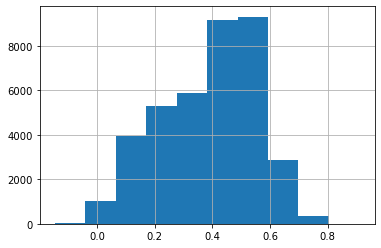

In [89]:
df_cov_mx[df_cov_mx.i!=df_cov_mx.j]['cov'].hist()

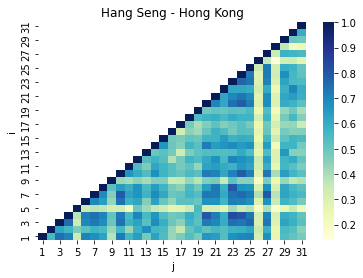

In [90]:
portfolio = 1
df_cov_pivot = df_cov_mx[df_cov_mx.port==portfolio].pivot(index='i', columns='j', values='cov')
sns.heatmap(df_cov_pivot.iloc[::-1], cmap="YlGnBu") 
plt.title(portfolios[portfolio])
ax=ax

### Fronteiras de Eficiência Irrestrira - UEF

In [91]:
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


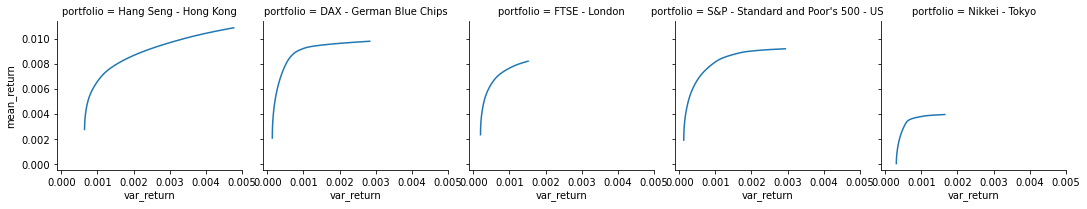

In [92]:
g = sns.relplot(data=uef, y='mean_return', x='var_return', col='portfolio', kind='line', height=3)
ax=ax

## Curvas de Aprendizado

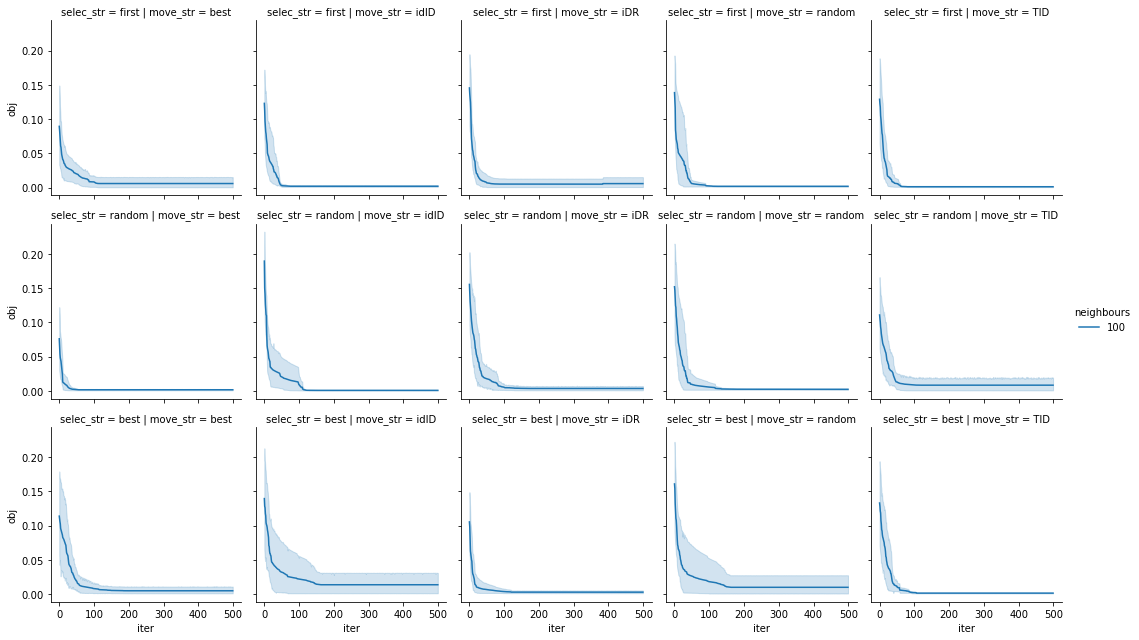

In [96]:
g = sns.FacetGrid(
    data=all_data, col='move_str', row='selec_str', hue='neighbours')
g.map(sns.lineplot, 'iter', 'obj')
g.add_legend()
g=g

In [97]:
g = sns.FacetGrid(
    data=all_data[all_data.iter>100], col='move_str', row='selec_str', hue='neighbours')
g.map(sns.lineplot, 'iter', 'obj')
g.add_legend()
g=g

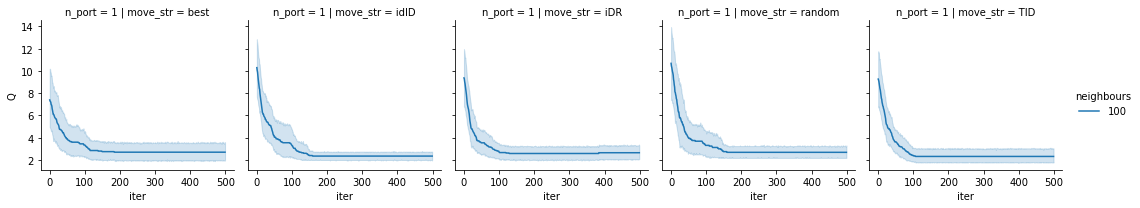

In [ ]:
g = sns.FacetGrid(
    data=all_data, col='move_str', row='selec_str', hue='neighbours')
g.map(sns.lineplot, 'iter', 'Q')
g.add_legend()
g=g

## Análise Best - Portfólio 1

In [61]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


In [62]:
print(best_data.shape)
best_data.drop(['X', 'Z',],axis=1,).head()

(32000, 18)


,iter,obj,aug_obj,return,Q,max_iter,neighbours,alpha,exp_return,n_port,k,move_str,seed,selec_str,filename,last_iter
0,0,0.218155,0.218155,0.004047,13.0,500,100,0.1,0.002,1,14,random,1,first,log_gls_20211117_204940_366583.csv,1
1,1,0.215330,0.215330,0.004056,13.0,500,100,0.1,0.002,1,14,random,1,first,log_gls_20211117_204940_366583.csv,1
2,2,0.212192,0.212192,0.004029,13.0,500,100,0.1,0.002,1,14,random,1,first,log_gls_20211117_204940_366583.csv,1
3,3,0.180683,0.180683,0.002961,13.0,500,100,0.1,0.002,1,14,random,1,first,log_gls_20211117_204940_366583.csv,1
4,4,0.175442,0.175442,0.002909,13.0,500,100,0.1,0.002,1,14,random,1,first,log_gls_20211117_204940_366583.csv,1


In [63]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,32000.0,249.500000,1.443395e+02,0.000000,124.750000,249.500000,374.250000,499.000000
obj,32000.0,0.010274,2.837053e-02,0.000078,0.000652,0.001381,0.002338,0.253768
aug_obj,32000.0,0.010274,2.837053e-02,0.000078,0.000652,0.001381,0.002338,0.253768
return,32000.0,0.002795,2.292336e-03,0.000282,0.001487,0.002362,0.003153,0.010803
Q,32000.0,3.314969,3.259242e+00,1.000000,2.000000,2.000000,3.000000,22.000000
max_iter,32000.0,500.000000,0.000000e+00,500.000000,500.000000,500.000000,500.000000,500.000000
neighbours,32000.0,100.000000,0.000000e+00,100.000000,100.000000,100.000000,100.000000,100.000000
alpha,32000.0,0.100000,1.387800e-17,0.100000,0.100000,0.100000,0.100000,0.100000
exp_return,32000.0,0.002234,1.908008e-03,0.000500,0.001000,0.001500,0.003000,0.010000
n_port,32000.0,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000


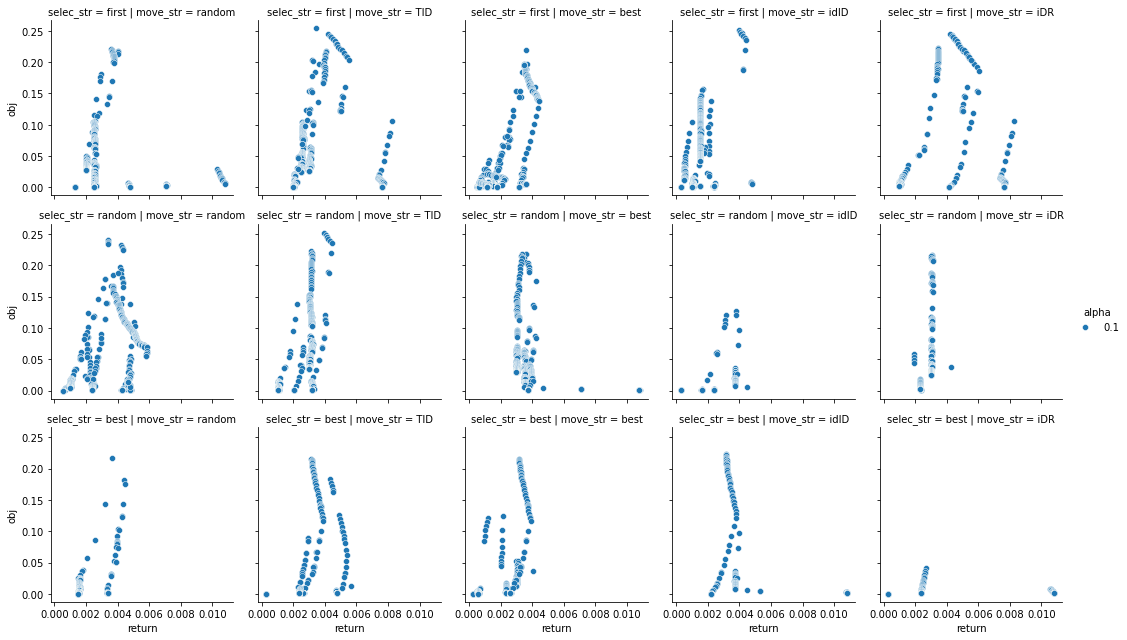

In [64]:
g = sns.FacetGrid(data=best_data, col='move_str', row='selec_str', hue='alpha')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

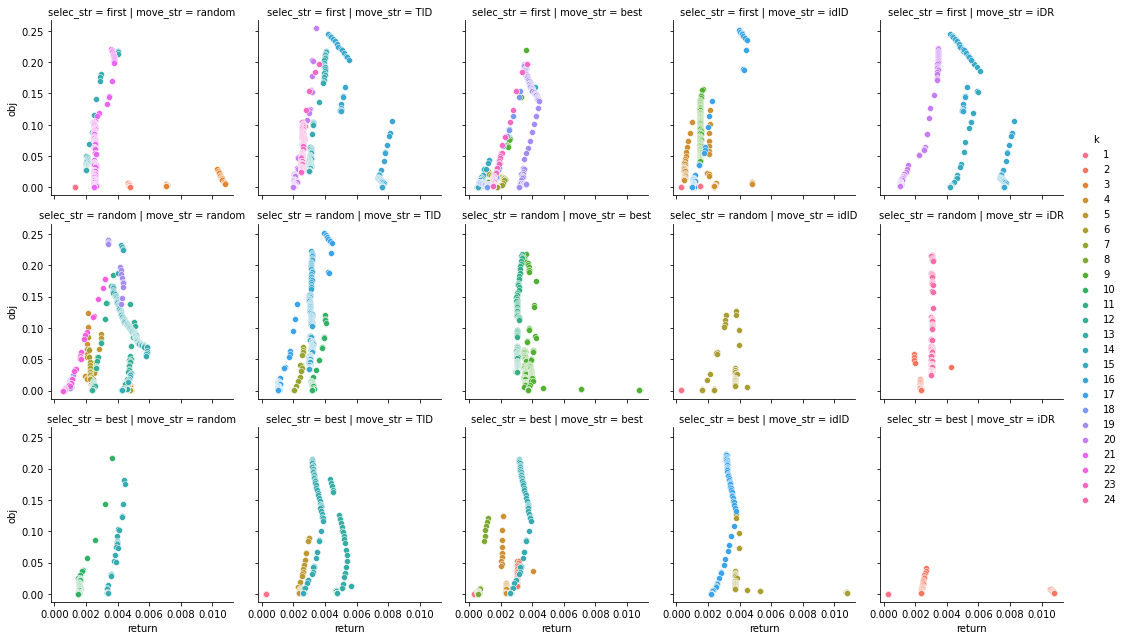

In [65]:
g = sns.FacetGrid(data=best_data, col='move_str', row='selec_str', hue='k')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

In [66]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,32000.0,249.500000,1.443395e+02,0.000000,124.750000,249.500000,374.250000,499.000000
obj,32000.0,0.010274,2.837053e-02,0.000078,0.000652,0.001381,0.002338,0.253768
aug_obj,32000.0,0.010274,2.837053e-02,0.000078,0.000652,0.001381,0.002338,0.253768
return,32000.0,0.002795,2.292336e-03,0.000282,0.001487,0.002362,0.003153,0.010803
Q,32000.0,3.314969,3.259242e+00,1.000000,2.000000,2.000000,3.000000,22.000000
max_iter,32000.0,500.000000,0.000000e+00,500.000000,500.000000,500.000000,500.000000,500.000000
neighbours,32000.0,100.000000,0.000000e+00,100.000000,100.000000,100.000000,100.000000,100.000000
alpha,32000.0,0.100000,1.387800e-17,0.100000,0.100000,0.100000,0.100000,0.100000
exp_return,32000.0,0.002234,1.908008e-03,0.000500,0.001000,0.001500,0.003000,0.010000
n_port,32000.0,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


In [68]:
uef[uef.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
mean_return,2000.0,0.006825,0.002334,0.002784,0.004804,0.006825,0.008845,0.010865
var_return,2000.0,0.001579,0.001116,0.000642,0.000716,0.001058,0.002150,0.004776
port,2000.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0, 0.5, 'mean_return')

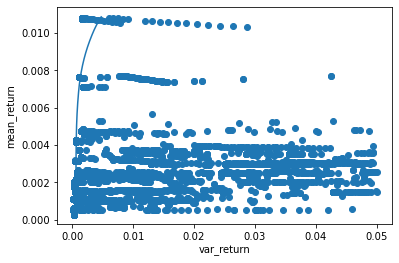

In [69]:
data = best_data[best_data['obj']<0.05]
data = data[data.n_port==1]
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return)
plt.scatter(data.obj, data['return'])
plt.xlabel("var_return")
plt.ylabel("mean_return")

In [70]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,32000.0,249.500000,1.443395e+02,0.000000,124.750000,249.500000,374.250000,499.000000
obj,32000.0,0.010274,2.837053e-02,0.000078,0.000652,0.001381,0.002338,0.253768
aug_obj,32000.0,0.010274,2.837053e-02,0.000078,0.000652,0.001381,0.002338,0.253768
return,32000.0,0.002795,2.292336e-03,0.000282,0.001487,0.002362,0.003153,0.010803
Q,32000.0,3.314969,3.259242e+00,1.000000,2.000000,2.000000,3.000000,22.000000
max_iter,32000.0,500.000000,0.000000e+00,500.000000,500.000000,500.000000,500.000000,500.000000
neighbours,32000.0,100.000000,0.000000e+00,100.000000,100.000000,100.000000,100.000000,100.000000
alpha,32000.0,0.100000,1.387800e-17,0.100000,0.100000,0.100000,0.100000,0.100000
exp_return,32000.0,0.002234,1.908008e-03,0.000500,0.001000,0.001500,0.003000,0.010000
n_port,32000.0,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000


In [71]:
best_data['min_obj'] = best_data.groupby(['exp_return', 'k'], as_index=False)['obj'].transform(min)
best_best_data = best_data[best_data.obj==best_data.min_obj]
print(best_best_data.shape)

(24317, 19)


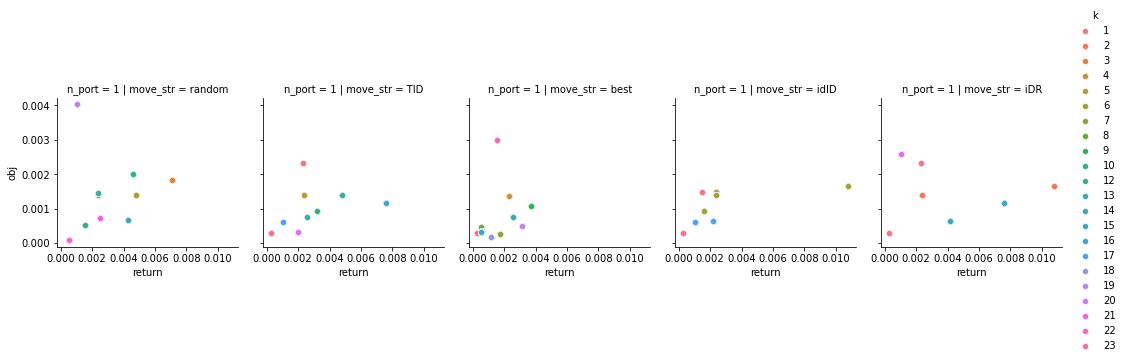

In [72]:
g = sns.FacetGrid(data=best_best_data[best_best_data.obj<0.01], col='move_str', row='selec_str')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

Text(0, 0.5, 'mean_return')

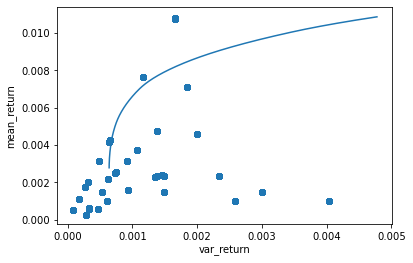

In [73]:
port = 1
data = best_best_data[best_best_data.n_port==port]
data = data[data['obj']<0.005]
plt.plot(uef[uef.port==port].var_return, uef[uef.port==port].mean_return)
plt.scatter(data.obj, data['return'])
plt.xlabel("var_return")
plt.ylabel("mean_return")

In [74]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .count()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

exp_return          0.0005  0.0010  0.0015  0.0020  0.0025  0.0030  0.0035  \
move_str selec_str                                                           
TID      best        500.0   500.0   500.0     NaN   500.0     NaN     NaN   
         first         NaN     NaN   500.0   500.0   500.0   500.0     NaN   
         random        NaN  1000.0     NaN     NaN     NaN  1000.0     NaN   
best     best        500.0   500.0     NaN  1000.0     NaN   500.0     NaN   
         first      1500.0   500.0   500.0     NaN     NaN   500.0     NaN   
         random        NaN     NaN     NaN     NaN     NaN   500.0  1000.0   
iDR      best          NaN   500.0     NaN     NaN     NaN     NaN     NaN   
         first         NaN   500.0     NaN     NaN     NaN   500.0     NaN   
         random        NaN     NaN   500.0     NaN   500.0   500.0     NaN   
idID     best          NaN     NaN   500.0     NaN   500.0     NaN     NaN   
         first      1000.0  1000.0   500.0     NaN     NaN     NaN     NaN   
         random        NaN     NaN  1000.0   500.0     NaN     NaN     NaN   
random   best          NaN   500.0   500.0     NaN     NaN     NaN     NaN   
         first       500.0  1000.0     NaN   500.0   500.0     NaN     NaN   
         random     1000.0  1000.0   500.0   500.0     NaN     NaN  1000.0   

exp_return          0.0040  0.0050  0.0055  0.0060  0.0070  0.0090  0.0100  
move_str selec_str                                                          
TID      best          NaN     NaN   500.0   500.0     NaN     NaN     NaN  
         first         NaN     NaN     NaN     NaN     NaN     NaN     NaN  
         random        NaN     NaN     NaN     NaN     NaN     NaN     NaN  
best     best          NaN     NaN     NaN     NaN     NaN     NaN     NaN  
         first         NaN     NaN     NaN     NaN     NaN     NaN     NaN  
         random        NaN     NaN     NaN     NaN     NaN     NaN     NaN  
iDR      best          NaN     NaN     NaN     NaN     NaN   500.0   500.0  
         first       500.0     NaN     NaN     NaN     NaN     NaN     NaN  
         random        NaN     NaN     NaN     NaN     NaN     NaN     NaN  
idID     best          NaN     NaN     NaN     NaN     NaN     NaN     NaN  
         first         NaN   500.0     NaN     NaN     NaN     NaN     NaN  
         random        NaN     NaN     NaN     NaN     NaN     NaN     NaN  
random   best          NaN     NaN     NaN     NaN     NaN     NaN     NaN  
         first         NaN     NaN     NaN     NaN   500.0     NaN     NaN  
         random        NaN     NaN     NaN     NaN     NaN     NaN     NaN

In [75]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .min()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

exp_return            0.0005    0.0010    0.0015    0.0020    0.0025  \
move_str selec_str                                                     
TID      best       0.001381  0.000745  0.001381       NaN  0.001385   
         first           NaN       NaN  0.001169  0.000316  0.024365   
         random          NaN  0.000615       NaN       NaN       NaN   
best     best       0.000471  0.000282       NaN  0.000745       NaN   
         first      0.000171  0.000267  0.003003       NaN       NaN   
         random          NaN       NaN       NaN       NaN       NaN   
iDR      best            NaN  0.001381       NaN       NaN       NaN   
         first           NaN  0.002578       NaN       NaN       NaN   
         random          NaN       NaN  0.001381       NaN  0.002338   
idID     best            NaN       NaN  0.000631       NaN  0.001657   
         first      0.000282  0.000615  0.042776       NaN       NaN   
         random          NaN       NaN  0.000282  0.001388       NaN   
random   best            NaN  0.001451  0.000529       NaN       NaN   
         first      0.001309  0.001309       NaN  0.027823  0.000728   
         random     0.000078  0.001381  0.001381  0.001455       NaN   

exp_return            0.0030    0.0035    0.0040    0.0050    0.0055  \
move_str selec_str                                                     
TID      best            NaN       NaN       NaN       NaN  0.000282   
         first      0.025502       NaN       NaN       NaN       NaN   
         random     0.000916       NaN       NaN       NaN       NaN   
best     best       0.012895       NaN       NaN       NaN       NaN   
         first      0.000482       NaN       NaN       NaN       NaN   
         random     0.029661  0.001074       NaN       NaN       NaN   
iDR      best            NaN       NaN       NaN       NaN       NaN   
         first      0.001169       NaN  0.000638       NaN       NaN   
         random     0.025017       NaN       NaN       NaN       NaN   
idID     best            NaN       NaN       NaN       NaN       NaN   
         first           NaN       NaN       NaN  0.001487       NaN   
         random          NaN       NaN       NaN       NaN       NaN   
random   best            NaN       NaN       NaN       NaN       NaN   
         first           NaN       NaN       NaN       NaN       NaN   
         random          NaN  0.000652       NaN       NaN       NaN   

exp_return            0.0060    0.0070    0.0090    0.0100  
move_str selec_str                                          
TID      best       0.002338       NaN       NaN       NaN  
         first           NaN       NaN       NaN       NaN  
         random          NaN       NaN       NaN       NaN  
best     best            NaN       NaN       NaN       NaN  
         first           NaN       NaN       NaN       NaN  
         random          NaN       NaN       NaN       NaN  
iDR      best            NaN       NaN  0.001654  0.000282  
         first           NaN       NaN       NaN       NaN  
         random          NaN       NaN       NaN       NaN  
idID     best            NaN       NaN       NaN       NaN  
         first           NaN       NaN       NaN       NaN  
         random          NaN       NaN       NaN       NaN  
random   best            NaN       NaN       NaN       NaN  
         first           NaN  0.001837       NaN       NaN  
         random          NaN       NaN       NaN       NaN

In [76]:
best_best_data = best_data.groupby(['exp_return'], as_index=False)['obj'].min()
print(best_best_data.shape)
best_best_data.head()

(14, 2)


,exp_return,obj
0,0.0005,0.000078
1,0.0010,0.000267
2,0.0015,0.000282
3,0.0020,0.000316
4,0.0025,0.000728


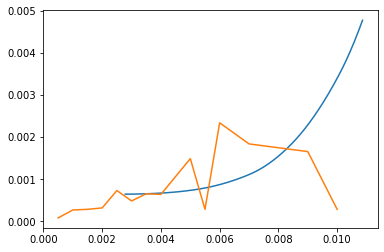

In [77]:
plt.plot(uef[uef.port==1].mean_return, uef[uef.port==1].var_return)
plt.plot(best_best_data.exp_return, best_best_data.obj)